# DTWKmeans Time series clustering

### Demo notebook for pynuTS 

Perform some experiments with pynuTS DTW based clustering:

- Clustering of binary channel symbols
- Clustering of slopes


In [1]:
# allow import from parent directory
import sys,os
sys.path.append(os.getcwd() + '/..')

In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pynuTS.clustering import DTWKmeans

In [3]:
# import helper functions for dataset generation
from ts_gen import make_binary_code_dataset,make_flat_dataset,make_slopes_dataset
# import helper functions for dataset visualization
from ts_viz import plot_list_of_ts,plot_list_of_ts_over_subplots

### Helper functions to extend pynuTS API
the functions below are candidate to be integrated into pynuTS 

In [4]:
def get_clustered_list(list_of_series,clusters_dict):
    """Return a list of pandas series with series names adjusted according to the given clusters dictionary
    
    Arguments:
 
    list_of_series : list of Pandas Series. the name of the series is irrelevent

    clusters_dict : dictiorary associating clusters and series indexes in the input list
        example:  {0: [6, 7, 8], 1: [0, 1, 2], 2: [3, 4, 5]}
        means: cluster 0 is composed by series 6,7,8
               cluster 1 is composed by series 0,1,2
               cluster 2 is composed by series 3,4,5

    Returns:  copy of the list of series with names matching the clusters_dict
    """
    new_list = list_of_series.copy()
    for k in clusters_dict.keys():
        for i in clusters_dict[k]:
            new_list[i].name = k
    return new_list

## Test dataset building functions: Binary timeseries
Synthetic time series representing binary codes.

The generated time series are similar to the output of a digital oscilloscope sampling an NRZ serial channel with some white noise 

#### Binary training dataset generation 

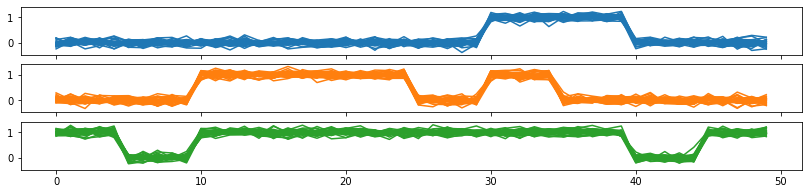

In [5]:
codes = [12,232,765]
samples = 30 #per type
list_of_series = make_binary_code_dataset(codes,samples,additive_noise_factor=0.1,lengths=[50])
plot_list_of_ts_over_subplots(list_of_series)

#### pynuTS clusterization

In [6]:
clts = DTWKmeans(num_clust = 3, num_iter = 10, w=1,euclidean=True)
clts.fit(list_of_series)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


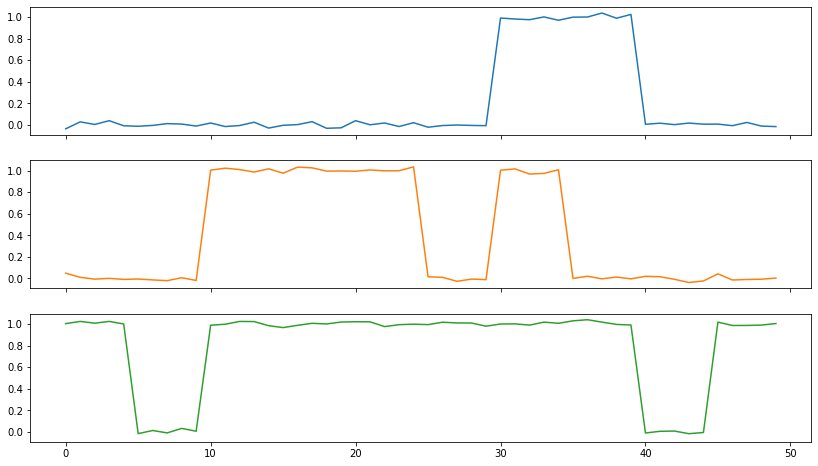

In [7]:
centroids_list = [pd.Series(c, name=i) for i,c in enumerate(clts.cluster_centers_)]
plot_list_of_ts_over_subplots(centroids_list,figsize=(14,8))

#### Check clustering on the training set

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 1: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 2: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]}


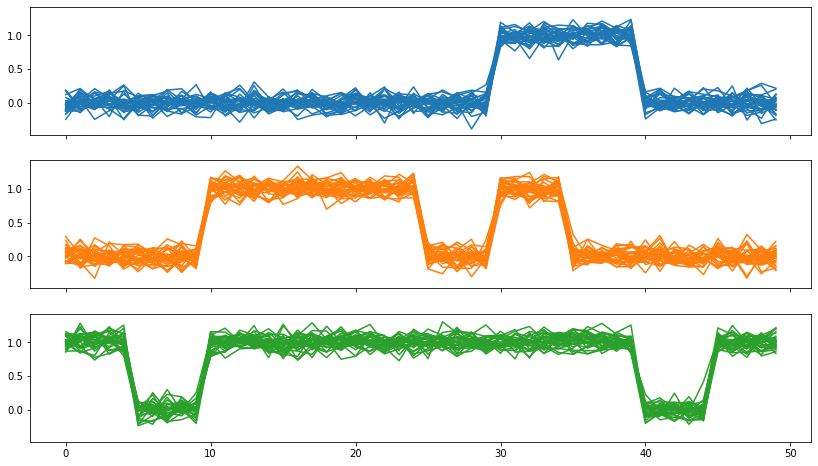

In [8]:
clustering_dict = clts.predict(list_of_series)
print(clustering_dict)
plot_list_of_ts_over_subplots(get_clustered_list(list_of_series,clustering_dict),figsize=(14,8))
#plot_list_of_ts(get_clustered_list(list_of_series,clustering_dict),figsize=(14,8))

#### New data generation

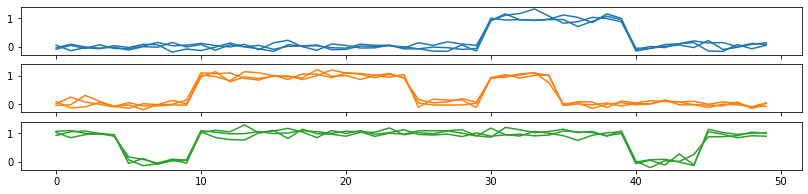

In [10]:
list_new = make_binary_code_dataset(codes,3,additive_noise_factor=0.1,lengths=[50])
plot_list_of_ts_over_subplots(list_new)

#### Clustering of new data

In [11]:
clustering_dict = clts.predict(list_new)
clustering_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7, 8]}

#### Check results

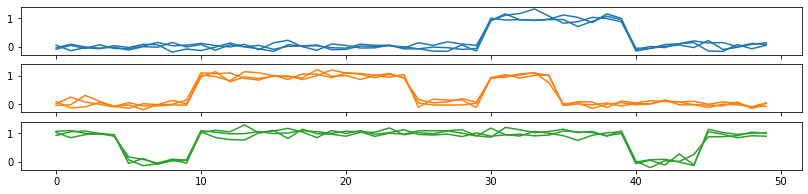

In [12]:
plot_list_of_ts_over_subplots(get_clustered_list(list_new,clustering_dict))

## Test dataset building functions: Monotonic + random
Synthetic time series of various constant slopes


#### Constant slope training dataset generation 

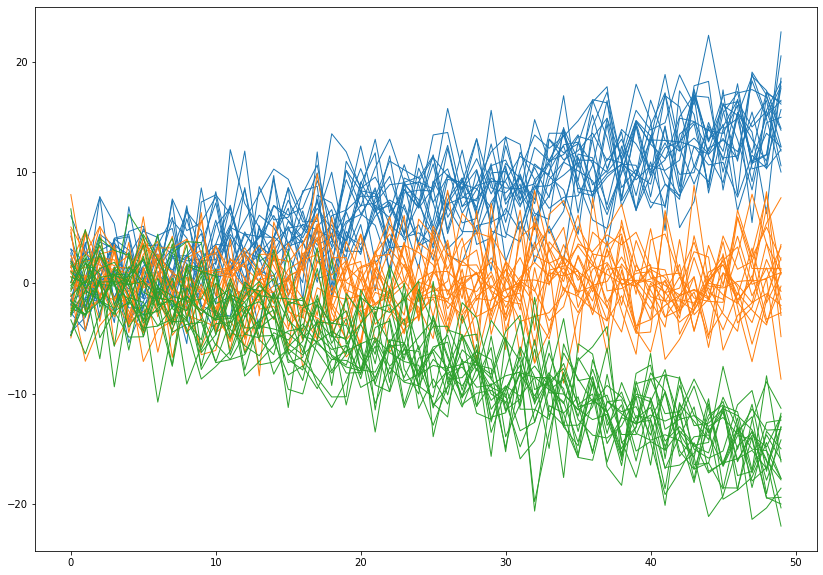

In [15]:
slopes = [0.3,0,-0.3]
list_of_series = make_slopes_dataset(slopes,20,additive_noise_factor=3.0,intercept_noise_factor=0.05,lengths=[50])
#plot_list_of_ts_over_subplots(list_of_series,figsize=(14,8))
plot_list_of_ts(list_of_series,figsize=(14,10))
plt.show()

#### pynuTS clusterization

In [16]:
clts = DTWKmeans(num_clust = 3, num_iter = 40, w=1,euclidean=True)
clts.fit(list_of_series)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:35<00:00,  1.13it/s]


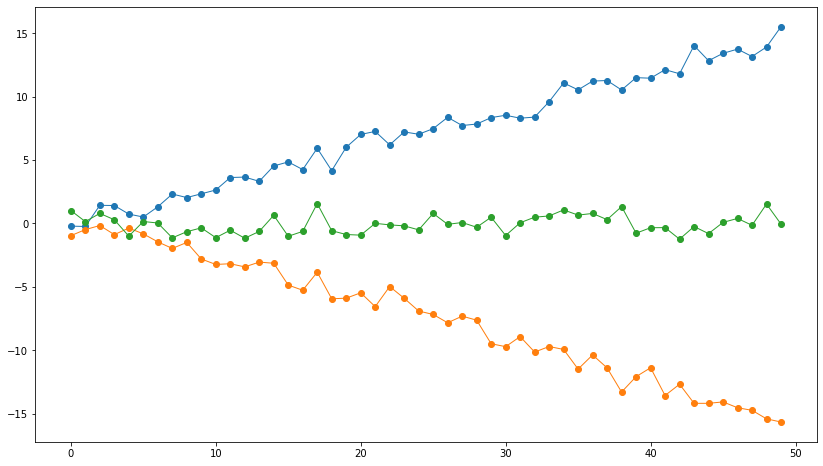

In [17]:
centroids_list = [pd.Series(c, name=i) for i,c in enumerate(clts.cluster_centers_)]
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')


#### Check clustering on the training set

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 1: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]}


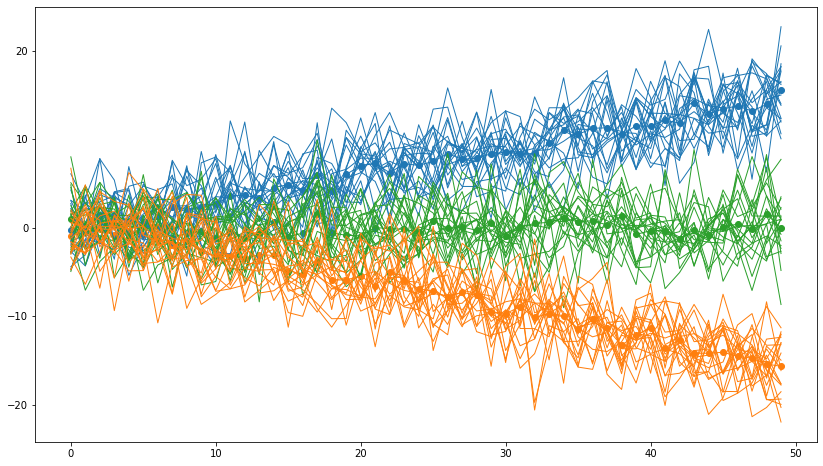

In [18]:
clustering_dict = clts.predict(list_of_series)
print(clustering_dict)
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')
plot_list_of_ts(get_clustered_list(list_of_series,clustering_dict),figure=fig)
plt.show()

#### New data generation

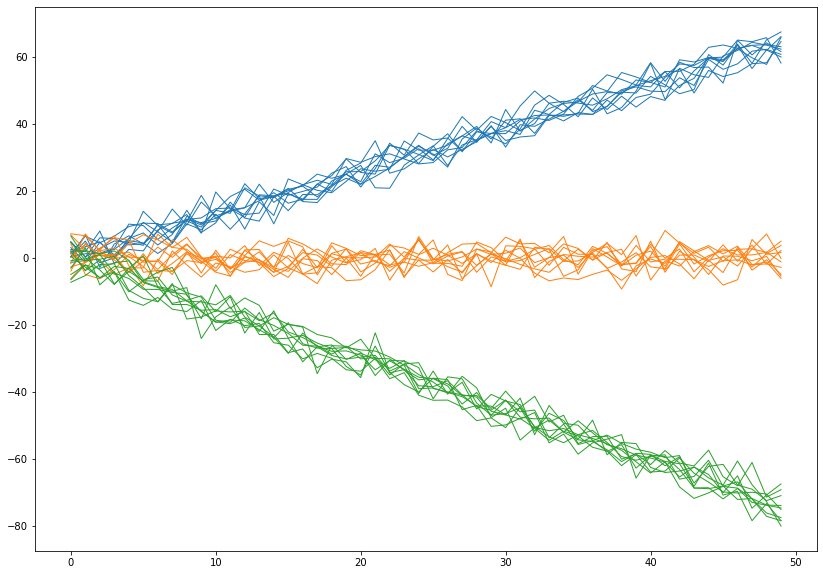

In [19]:
slopes = [1.3,0.0,-1.5]
list_new = make_slopes_dataset(slopes,10,additive_noise_factor=2.9,intercept_noise_factor=0.1,lengths=[50])
#plot_list_of_ts_over_subplots(list_of_series,figsize=(14,8))
plot_list_of_ts(list_new,figsize=(14,10))
plt.show()

#### Clustering of new data

In [20]:
clustering_dict = clts.predict(list_new)
clustering_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 1: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}

#### Check results

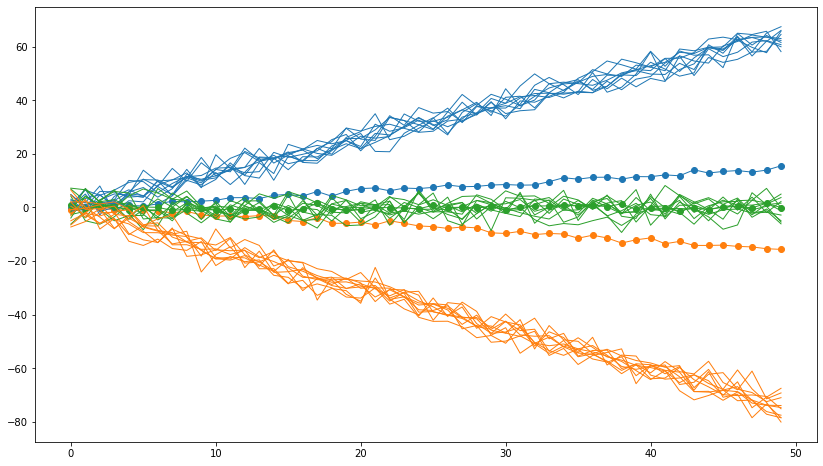

In [21]:
#plot_list_of_ts_over_subplots(get_clustered_list(list_new,clustering_dict),figsize=(14,8))
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')
plot_list_of_ts(get_clustered_list(list_new,clustering_dict),figure=fig)
plt.show()

# Unit Test 
This is the example dataset described in the docstring of DTWKmeans class in the original repo and included also in the unit test 

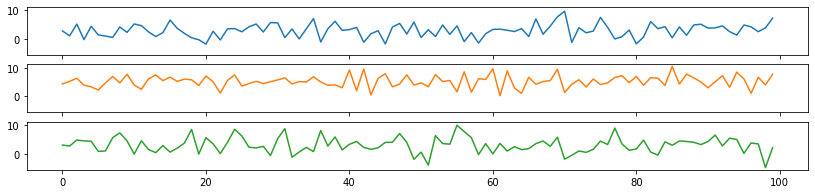

In [22]:
ts1 = 2.5 * np.random.randn(100,) + 3
X_1 = pd.Series(ts1,name=0)
ts2 = 2 * np.random.randn(100,) + 5
X_2 = pd.Series(ts2,name=1)
ts3 = -2.5 * np.random.randn(100,) +3
X_3 = pd.Series(ts3,name=2)
list_of_series = [X_1, X_2, X_3]

plot_list_of_ts_over_subplots(list_of_series)

In [23]:
clts = DTWKmeans(num_clust = 3, num_iter = 5)
clts.fit(list_of_series)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


In [24]:
ts4 = 3.5 * np.random.randn(100,) + 20
ts5 = -3.5 * np.random.randn(100,) - 20
X_4 = pd.Series(ts4)
X_5 = pd.Series(ts5)
list_new = [X_4, X_5]

In [25]:
clustering_dict = clts.predict(list_new)
clustering_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [], 1: [0], 2: [1]}

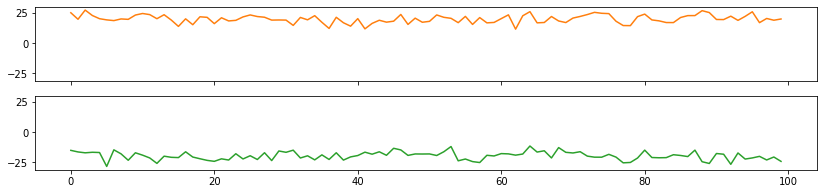

In [26]:
plot_list_of_ts_over_subplots(get_clustered_list(list_new,clustering_dict))

### Credits

pynuTS by Nicola Procopio 2020

Original repository https://github.com/nickprock/pynuTS/

Demo notebook by Marcello Morchio 2020

Forked repository https://github.com/mallibus/pynuTS